# Analisis explorativo del dataset
## Fuente
https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews?resource=download
## Variables
- **Clothing ID**: Variable categórica entera que se refiere a la pieza específica que está siendo revisada.
- **Age**: Variable entera positiva que representa la edad del revisor.
- **Title**: Variable de texto que contiene el título de la reseña.
- **Review Text**: Variable de texto que contiene el cuerpo de la reseña.
- **Rating**:  Variable ordinal entera positiva que representa la puntuación del producto otorgada por el cliente, donde 1 es la peor y 5 es la mejor.
- **Recommended IND**: Variable binaria que indica si el cliente recomienda el producto, donde 1 significa recomendado y 0 significa no recomendado.
- **Positive Feedback Count**: Variable entera positiva que registra la cantidad de otros clientes que encontraron esta reseña positiva.
- **Division Name**: Nombre categórico de alto nivel de la división del producto.
- **Department Name**:  Nombre categórico del departamento del producto.
- **Class Name**: Nombre categórico de la clase del producto.

 En este caso, el dataset ofrece tanto información del cliente, del producto y la reseña en si misma. Para el análisis con BERT solo interesa esta última división mencionada, que incluye, el *título*(title) como parte del contenido a analizar, el contenido de la reseña (review text), *Reccommended IND* que es un indicador del sentimiento de la reseña (positivo o negativo). 

Cargamos data y vemos un resumen del dataframe

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv('./w_reviews.csv', index_col=0)
print("Información general del conjunto de datos:")
print(data.info())

Información general del conjunto de datos:
<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB
None


Dado que parte fundamental del análisis son las columnas title y review text, revisamos que todas tenga un contenido valido, y en todo caso contamos los valores nulos o  NaN. 

- Filas eliminadas 3811 (por valores nulos en titulo y review text)
- Filas restantes: 19675 

In [36]:

# Elimino las filas que no tienen un contenido para el review Text
filas = data.shape[0]
data.dropna(subset=['Title', 'Review Text'], inplace=True)
print(f"Filas eliminadas {filas-data.shape[0]}\nFilas restantes: {data.shape[0]} ")



Filas eliminadas 3811
Filas restantes: 19675 


In [37]:
data['Text'] = data['Title'].apply(str) + '. ' + data['Review Text'].apply(str)
# Verificamos la eliminación anterior haya asegurado que no haya nulos en este campo
print(data[['Text']].isnull().sum())

Text    0
dtype: int64


Dado que nuestra variable para evaluar es *Reccommended IND*. Debemos verificar que este balanceada en cuanto a sus valores.

In [38]:
recommended_counts = data['Recommended IND'].value_counts()
positivo = recommended_counts[1]
negativo = recommended_counts[0]
total = data.shape[0]
print(f"Datos positivos: {positivo} ({100*positivo/total:.2f}%)")
print(f"Datos negativos: {negativo} ({100*negativo/total:.2f}%)")
print(f"Datoa a eliminar para balancear: {positivo-negativo} ({100*(positivo-negativo)/total:.2f}%)")


Datos positivos: 16100 (81.83%)
Datos negativos: 3575 (18.17%)
Datoa a eliminar para balancear: 12525 (63.66%)


El dataset está muy desbalanceado y para este dataset externo lo mejor sería eliminar datos de reviews positivos. Pero también implica perder hasta 63.66% de los datos. Lo hacemos para preparar el dataset pero un dataset con 6k tiene menos entrenamiento que el que ofrece el dataset original. 

In [39]:
def random_delete(dataset, num_filas, column, value):

    to_delete = dataset[dataset[column] == value]

    if num_filas > len(to_delete):
        raise Exception('El número de filas para eliminar es mayor que las filas disponibles con ese valor.')

    indices_to_delete = np.random.choice(to_delete.index, num_filas, replace=False)

    dataset = dataset.drop(indices_to_delete)

    return dataset
data = random_delete(data, positivo-negativo, 'Recommended IND', 1)

Revisando el balance nuevamente...

In [40]:
recommended_counts = data['Recommended IND'].value_counts()
positivo = recommended_counts[1]
negativo = recommended_counts[0]
total = data.shape[0]
print(f"Datos positivos: {positivo} ({100*positivo/total:.2f}%)")
print(f"Datos negativos: {negativo} ({100*negativo/total:.2f}%)")
print(f"Datoa a eliminar para balancear: {positivo-negativo} ({100*(positivo-negativo)/total:.2f}%)")

Datos positivos: 3575 (50.00%)
Datos negativos: 3575 (50.00%)
Datoa a eliminar para balancear: 0 (0.00%)


Realizamos una revisión de largo del texto a analizar como referencia.

Estadísticas de la longitud de textos:
count    7150.000000
mean      343.678741
std       142.413054
min        33.000000
25%       225.000000
50%       342.000000
75%       500.000000
max       558.000000
Name: Text Length, dtype: float64


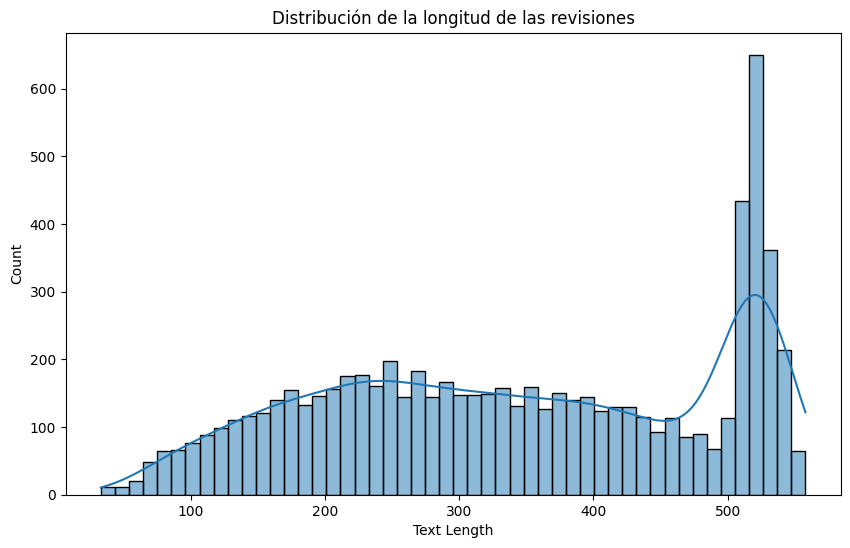

In [41]:
data['Text Length'] = data['Text'].apply(lambda x: len(str(x)))
print("Estadísticas de la longitud de textos:")
print(data['Text Length'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data['Text Length'], bins=50, kde=True)
plt.title('Distribución de la longitud de las revisiones')
plt.show()

La estadística descriptiva parece indicar que son textos con suficiente contexto 